In [690]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from torchinfo import summary
from adopt import ADOPT

In [692]:
data = pd.read_csv("../BIGDATA/jandata.csv")

In [693]:
print(f"The number of features available to us: {data.shape[1]}")
print(data.columns)

The number of features available to us: 56
Index(['time', 'comid', 'catid', 'du', 'pair_id', 'U2D', 'V2D', 'LWDOWN',
       'RAINRATE', 'T2D', 'Q2D', 'PSFC', 'SWDOWN', 'streamflow',
       'elevation_mean', 'slope_mean', 'impervious_mean', 'aspect_c_mean',
       'twi_dist_4', 'X', 'Y', 'gw_Coeff', 'gw_Zmax', 'gw_Expon',
       'bexp_soil_layers_stag=1', 'bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'ISLTYP',
       'IVGTYP', 'dksat_soil_layers_stag=1', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4',
       'psisat_soil_layers_stag=1', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'cwpvt',
       'mfsno', 'mp', 'quartz_soil_layers_stag=1', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'refkdt',
       'slope', 'smcmax_soil_layers_stag=1', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcm

In [695]:
def load_data_in_dictionary(data):
    '''This loads the data into a dictionary. each index of dictionary has a pair of watersheds, 
       upper and lower, and their features are merged in the for loop below'''
    num_networks = 0
    network_dict = {}
    broken_pairs = []
    for i in range(int((data['pair_id']).max())+1):
        try:
            downstream = data[(data['pair_id']== i) & (data['du'] == 'd')]
            upstream = data[(data['pair_id']== i) & (data['du'] == 'u')]
            #print(downstream)
            #print(upstream)
            if downstream.empty or downstream.isnull().values.any():
                print(i, " DS is empty")
                continue
            if upstream.empty or upstream.isnull().values.any():
                print(i, " US is empty")
                continue
            '''area_ratio = upstream.iloc[0]["Shape_Area"] / downstream.iloc[0]["Shape_Area"]
            if area_ratio > 1:
                print(i, " area ratio too large")
                continue
            if abs(downstream.iloc[-1]['ID'] - upstream.iloc[-1]['ID']) > 100:
                print(i, " DS and US too far apart")
                continue'''
            network = downstream.merge(upstream, on="time")
            # network.drop(["x_x", "y_x", "pair_id_x", "x_y", "y_y", "pair_id_y"], axis=1, inplace=True)
            network_dict[num_networks] = network
            num_networks += 1
        except:
            broken_pairs.append(i)
            raise Exception
    return network_dict, broken_pairs, num_networks



network_dict, num_networks, broken_pairs = load_data_in_dictionary(data)

print(f"The number of networks we have:\t{len(network_dict)}")
print(f"The number of data points in each network:\t{network_dict[0].shape[0]}")
print(f"The number of features in each network:\t{network_dict[0].shape[1]}")

33  DS is empty
36  US is empty
65  US is empty
169  DS is empty
170  US is empty
195  US is empty
199  DS is empty
270  US is empty
281  DS is empty
291  DS is empty
303  DS is empty
331  DS is empty
390  US is empty
425  US is empty
457  US is empty
500  US is empty
The number of networks we have:	485
The number of data points in each network:	744
The number of features in each network:	111


In [696]:
def correlation_with_lstm_output(correlation_inputs, correlation_outputs):
    correlation_data = correlation_inputs + correlation_outputs
    frames = [network_dict[ibuc].loc[:, correlation_data] for ibuc in [0,1,5,6]]
    df_in = pd.concat(frames)
    correlation_matrix = np.corrcoef(df_in)

    for i in range(len(correlation_outputs)):
        print(f"Correlation with {correlation_outputs[i]}")
        for j in range(len(correlation_data)):
            print(f"{correlation_data[j]}: {correlation_matrix[i+len(correlation_inputs)][j]}")



In [697]:
#among all the features in the dataset, we will be working on thses features. If you want to add a new feature, see the datafile and add features as you like

# lstm_inputs = [
#     'precip_rate_x', 
#     'TMP_2maboveground_x', 
#     'UGRD_10maboveground_x',
#     'APCP_surface_x', 
#     'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
#     'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
#     'streamflow_x',
#     'precip_rate_y', 
#     'TMP_2maboveground_y', 
#     'UGRD_10maboveground_y',
#     'APCP_surface_y', 
#     'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
#     'impervious_mean_y', 'dksat_soil_layers_stag=1_y']
lstm_inputs = [ 'precip_rate_x', 
    'APCP_surface_x', 
               'TMP_2maboveground_x', 
    'DSWRF_surface_x', 'DLWRF_surface_x', 'PRES_surface_x', 
    'UGRD_10maboveground_x', 'VGRD_10maboveground_x', 'SPFH_2maboveground_x', 
    'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
    'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
    'streamflow_x',
    'precip_rate_y', 
    'APCP_surface_y', 
    'TMP_2maboveground_y',
    'DSWRF_surface_y', 'DLWRF_surface_y', 'PRES_surface_y',
    'UGRD_10maboveground_y', 'VGRD_10maboveground_y', 'SPFH_2maboveground_y',
    'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
    'impervious_mean_y', 'dksat_soil_layers_stag=1_y']


n_input = len(lstm_inputs)

lstm_outputs = ['streamflow_y']     #this is what we will be trying to predict using the LSTM model
n_output = len(lstm_outputs)
print(f"The number of features for LSTM model:\t{n_input}")

The number of features for LSTM model:	29


In [698]:
correlation_inputs = [
    'precip_rate_x', 
    'APCP_surface_x', 
               'TMP_2maboveground_x', 
    'DSWRF_surface_x', 'DLWRF_surface_x', 'PRES_surface_x', 
    'UGRD_10maboveground_x', 'VGRD_10maboveground_x', 'SPFH_2maboveground_x', 
    'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
    'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
    'streamflow_x',
    'precip_rate_y', 
    'APCP_surface_y', 
    'TMP_2maboveground_y',
    'DSWRF_surface_y', 'DLWRF_surface_y', 'PRES_surface_y',
    'UGRD_10maboveground_y', 'VGRD_10maboveground_y', 'SPFH_2maboveground_y',
    'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
    'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

correlation_with_lstm_output(correlation_inputs, lstm_outputs)

KeyError: "['precip_rate_x', 'APCP_surface_x', 'TMP_2maboveground_x', 'DSWRF_surface_x', 'DLWRF_surface_x', 'PRES_surface_x', 'UGRD_10maboveground_x', 'VGRD_10maboveground_x', 'SPFH_2maboveground_x', 'Shape_Area_x', 'precip_rate_y', 'APCP_surface_y', 'TMP_2maboveground_y', 'DSWRF_surface_y', 'DLWRF_surface_y', 'PRES_surface_y', 'UGRD_10maboveground_y', 'VGRD_10maboveground_y', 'SPFH_2maboveground_y', 'Shape_Area_y'] not in index"

In [660]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple M3/M2/M1 (Metal) device")
else:
    device = 'cpu'
    print("Using CPU")

# batch_size = 1704
seq_length = 270

Using CUDA device: NVIDIA A100-SXM4-40GB


In [661]:
n_networks = len(network_dict)

n_networks_split = {"train": (math.floor(n_networks * 0.7)), "val": math.floor(n_networks * 0.2), "test": math.floor(n_networks * 0.1)}
print(n_networks_split['val'])

1


In [662]:
def split_parameters(n_networks):
    # create lists of network indices for each set based on the given network splits
    networks_for_training = list(range(0, n_networks_split['train'] + 1))
    networks_for_val = list(range(n_networks_split['train'] + 1, 
                                 n_networks_split['train'] + n_networks_split['val'] + 1))

    if (n_networks_split['test'] > 0):
        networks_for_test = list(range(n_networks - n_networks_split['test'], n_networks))
    else:
        print("Since the dataset is small and no basins are available for testing. We give a random bucket to test.")
        random_bucket = np.random.randint(0, n_networks)
        networks_for_test = [random_bucket]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [networks_for_training]
    val_split_parameters = [networks_for_val]
    test_split_parameters = [networks_for_test]

    return [train_split_parameters, val_split_parameters, test_split_parameters]

[[networks_for_training], [networks_for_val], [networks_for_test]] = split_parameters(n_networks)
print(f"The networks for training is {networks_for_training}")
print(f"The networks for validation is {networks_for_val}")
print(f"The networks testing is {networks_for_test}")

Since the dataset is small and no basins are available for testing. We give a random bucket to test.
The networks for training is [0, 1, 2, 3, 4]
The networks for validation is [5]
The networks testing is [6]


Network: 0
Streamflow (downstream) mean: 0.42
Streamflow (upstream) mean: 0.42


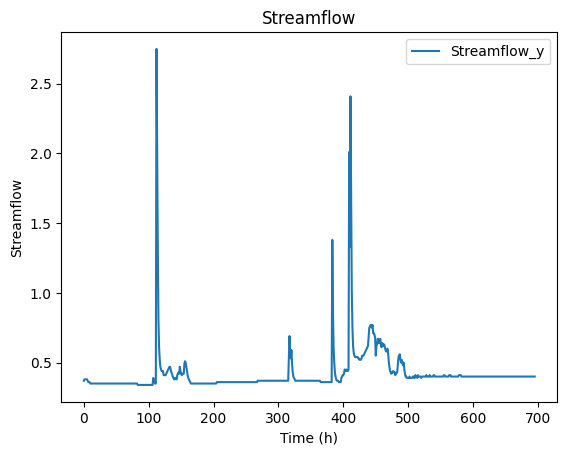

Network: 1
Streamflow (downstream) mean: 0.06
Streamflow (upstream) mean: 0.13


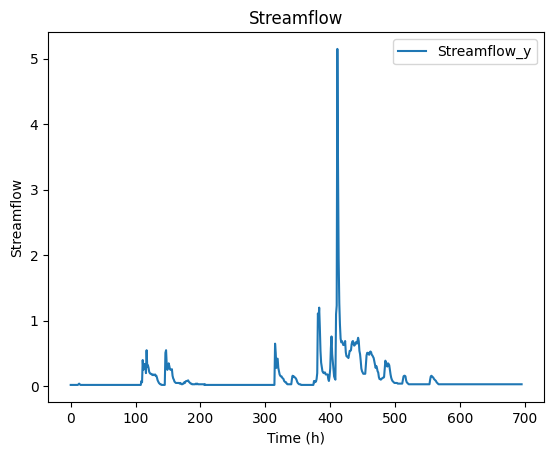

Network: 2
Streamflow (downstream) mean: 0.09
Streamflow (upstream) mean: 0.12


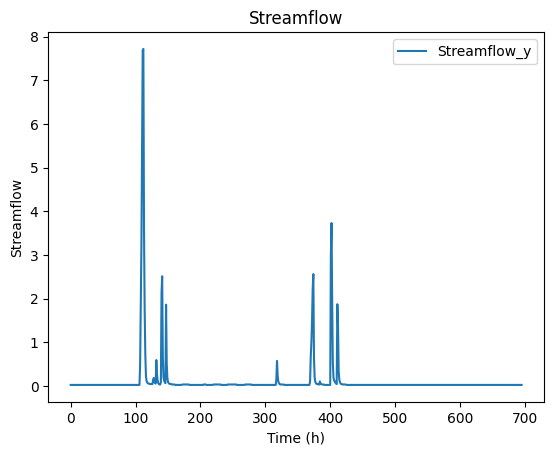

Network: 3
Streamflow (downstream) mean: 0.28
Streamflow (upstream) mean: 0.29


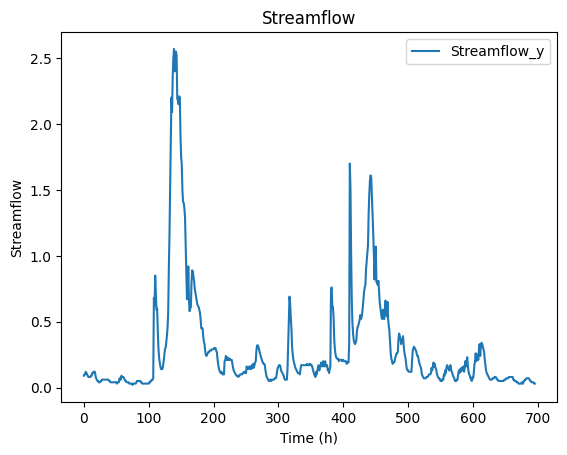

Network: 4
Streamflow (downstream) mean: 0.48
Streamflow (upstream) mean: 2.11


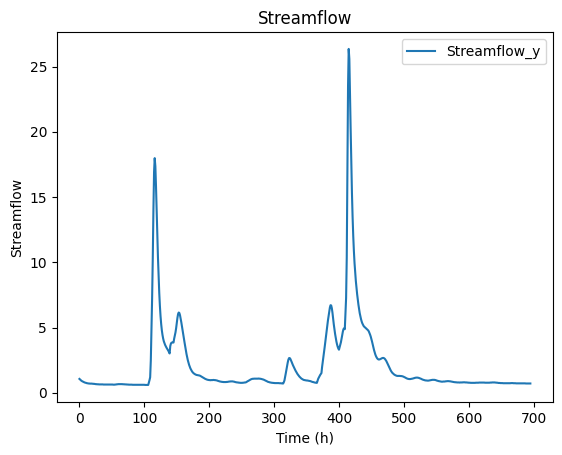

Network: 5
Streamflow (downstream) mean: 0.55
Streamflow (upstream) mean: 0.63


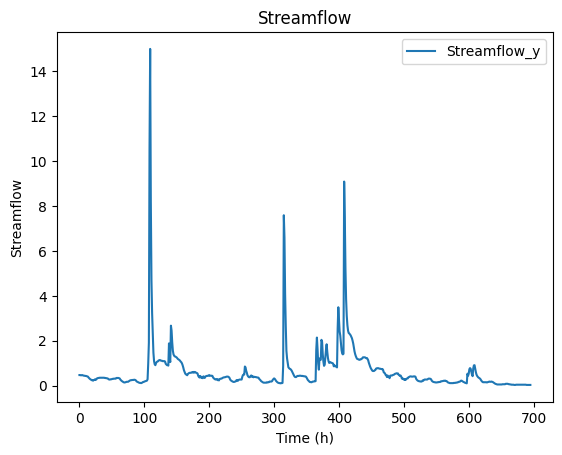

In [663]:
def viz_networks(ibuc):
    fig, ax = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(),2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(),2))

    # network_dict[ibuc].loc[:2000,['precip_rate_x']].plot(ax=ax, legend=False)
    network_dict[ibuc].loc[:2000,['streamflow_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['streamflow_x']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_x']].plot(ax=ax, legend=False)
    ax.set_title('Streamflow')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Streamflow')

    ax.legend(["Streamflow_y", "APCP_surface_x"])
    
    plt.show()
    plt.close()

def viz_networks2(ibuc):
    fig, ax1 = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(), 2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(), 2))

    # Plot streamflow_y on the primary y-axis
    network_dict[ibuc].loc[:2000, ['streamflow_x']].plot(ax=ax1, color = 'blue', legend=False)
    network_dict[ibuc].loc[:2000, ['streamflow_y']].plot(ax=ax1, color = 'purple', legend=False)
    ax1.set_title('Streamflow and Precipitation')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Streamflow')
    
    # Create a secondary y-axis and plot APCP_surface_x on it
    ax2 = ax1.twinx()
    network_dict[ibuc].loc[:2000, ['APCP_surface_x']].plot(ax=ax2, color='orange', legend=False)
    
    network_dict[ibuc].loc[:2000, ['APCP_surface_y']].plot(ax=ax2, color='red', legend=False)
    ax2.set_ylabel('APCP Surface')
    
    # Add legends for each axis
    ax1.legend(["Streamflow_y"], loc='upper left')
    ax2.legend(["APCP_surface_x"], loc='upper right')
    
    # plt.show()
    plt.close()

    

displayed = 0

for ibuc in networks_for_training:
    viz_networks(ibuc)
    displayed += 1


for ibuc in networks_for_val:
    viz_networks(ibuc)
    displayed += 1

In [664]:


class LSTM1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.normalization1 = nn.BatchNorm1d(256)
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64, bias = True),
            nn.ReLU(),
            nn.Linear(64, num_classes, bias=True)
        )

    def forward(self, x):
        out, _= self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = out[:,-1, :]
        out = self.normalization1(out)

        prediction = self.fc(out)
        return prediction



In [665]:

model = LSTM1(input_size=n_input, num_classes=n_output).to(device)

In [666]:
def fit_scaler():
    frames = [network_dict[ibuc].loc[:, lstm_inputs] for ibuc in [0,1,5,6]]
    df_in = pd.concat(frames)   
    print(df_in.shape)
    scaler_in = StandardScaler()
    scaler_in.fit(df_in)

    frames = [network_dict[ibuc].loc[:, lstm_outputs] for ibuc in [0,1,5,6]]
    df_out = pd.concat(frames)    
    print(df_out.shape)
    scaler_out = StandardScaler()
    scaler_out.fit(df_out)
    return scaler_in, scaler_out

In [667]:
scaler_in, scaler_out = fit_scaler()

(2784, 29)
(2784, 1)


In [668]:
def make_data_loader(network_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    for ibuc in network_list:
        df = network_dict[ibuc]
        scaler_in_i = scaler_in.transform(df.loc[:, lstm_inputs])
        scaler_out_i = scaler_out.transform(df.loc[:, lstm_outputs])
        
        n_samples = scaler_in_i.shape[0] - seq_length
        
        np_seq_X[ibuc] = np.zeros((n_samples, seq_length, n_input))
        np_seq_y[ibuc] = np.zeros((n_samples, n_output)) 

        for i in range(n_samples):
            t = i + seq_length
            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t, :]
            np_seq_y[ibuc][i, :] = scaler_out_i[t, :]

        ds = [torch.Tensor(np_seq_X[ibuc]), torch.Tensor(np_seq_y[ibuc])]
        loader[ibuc] = ds
    return loader, np_seq_X, np_seq_y

In [669]:
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader([0,1,5,6])
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader([2,4])
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(networks_for_test)

In [670]:
# print(train_loader[0][0].shape)
print(f"Each network has {train_loader[0][0].shape[0]} data points")
print(f"Each data point is made up of sequence of {train_loader[0][0].shape[1]} timesteps")
print(f"Each time step has {train_loader[0][0].shape[2]} features.")

Each network has 426 data points
Each data point is made up of sequence of 270 timesteps
Each time step has 29 features.


In [671]:
def concatanate_tensors(loader,  networks):
    concatanated_tensor_x = loader[networks[0]][0]
    concatanated_tensor_y = loader[networks[0]][1]

    for i in range(len(networks) - 1):
        concatanated_tensor_x = torch.cat((concatanated_tensor_x, loader[networks[i+1]][0]))
        concatanated_tensor_y = torch.cat((concatanated_tensor_y, loader[networks[i+1]][1]))
    return concatanated_tensor_x, concatanated_tensor_y    

  

In [672]:

print(networks_for_training)
train_data_x, train_data_y = concatanate_tensors(train_loader, [0,1,5,6])
val_data_x, val_data_y = concatanate_tensors(val_loader, [2,4])
test_data_x, test_data_y = concatanate_tensors(test_loader, networks_for_test)

[0, 1, 2, 3, 4]


In [673]:
batch_size = train_data_y.shape[0]
train_dataset = torch.utils.data.TensorDataset(train_data_x, train_data_y)
train_batch_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size)
val_dataset = torch.utils.data.TensorDataset(val_data_x, val_data_y)
val_batch_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size)
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)
print(f"Since each epoch will only have 1 batch of data, the batch size is set to the length of the entire data, which is {batch_size}.")

Since each epoch will only have 1 batch of data, the batch size is set to the length of the entire data, which is 1704.


In [674]:
def inverse_scale(scaler, numpy_value):
    transformed_numpy_value = scaler.inverse_transform(numpy_value)
    return transformed_numpy_value


In [675]:
def calculate_NSE(observed_value, modeled_value):
    mean_observed_value = np.mean(observed_value)
    numerator = np.sum(np.power((observed_value - modeled_value), 2))
    denominator = np.sum(np.power((observed_value - mean_observed_value), 2))
    return round((1 - (numerator/denominator)), 2) 

In [676]:
class EarlyStopper:
    def __init__(self, patience= 5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class EarlyStopperNSE:
    def __init__(self, patience= 5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_NSE = -100000000
    
    def early_stop(self, NSE):
        if (NSE >= self.max_NSE):
            self.max_NSE = NSE
            self.counter = 0
        elif NSE <= (self.max_NSE - self.min_delta):
            self.counter += 1
            if(self.counter) >= self.patience:
                return True
        return False

In [677]:
early_stopper = EarlyStopper(patience = 3, min_delta= 1)
early_stopper_NSE = EarlyStopperNSE(patience = 2, min_delta = 0.05)

In [678]:
def train_model(lstm, train_batch_loader):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(lstm.parameters(), lr= 0.001, weight_decay = 0.05)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 20, factor = 0.8)
    epochs = 200
    loss_history_train = []
    loss_history_val = []
    for epoch in range(epochs):
        NSE_batch_train = []
        NSE_batch_val = []
        for data, targets in train_batch_loader:
            x = data.to(device=device)
            y = targets.to(device=device)

            optimizer.zero_grad()
            predicted_y = lstm(x)
            loss = criterion(predicted_y, y)

            loss_history_train.append(loss.item())
            loss.backward()
            optimizer.step()
         
            with torch.no_grad():
                y_calc =  y.to("cpu").numpy()
                y_calc = inverse_scale(scaler_out, y_calc)
                y_calc = y_calc.reshape(y_calc.shape[0])

                predicted_y_calc =  predicted_y.to("cpu").numpy()
                predicted_y_calc = inverse_scale(scaler_out, predicted_y_calc)
                predicted_y_calc = predicted_y_calc.reshape(y_calc.shape[0])

                NSE_batch_train.append(calculate_NSE(y_calc, predicted_y_calc))

                
        lstm.eval()
        with torch.no_grad():
            for data, targets in val_batch_loader:
                x_calc = data.to(device=device)
                y_calc = targets.to(device=device)
                predicted_y_calc = lstm(x_calc)
                loss_calc = criterion(predicted_y_calc, y_calc)
                loss_history_val.append(loss_calc.item())
                y_calc =  y_calc.to("cpu").numpy()
                y_calc = inverse_scale(scaler_out, y_calc)
                y_calc = y_calc.reshape(y_calc.shape[0])
                predicted_y_calc =  predicted_y_calc.to("cpu").numpy()
                predicted_y_calc = inverse_scale(scaler_out, predicted_y_calc)
                predicted_y_calc = predicted_y_calc.reshape(y_calc.shape[0])

                NSE_batch_val.append(calculate_NSE(y_calc, predicted_y_calc))
                
            if early_stopper_NSE.early_stop(np.mean(NSE_batch_val)):
                break

        scheduler.step(loss_calc)
        lstm.train()


        print(f"Epoch: {epoch + 1} Completed\tLoss_Train: {loss_history_train[-1]:.4f}\tNSE_Train: {np.mean(NSE_batch_train):.4f}\tLoss_Val: {loss_history_val[-1]:.4f}\tNSE_Validation:{np.mean(NSE_batch_val):.4f}\t Learning_Rate: {optimizer.param_groups[0]['lr']})")
        

    return lstm, loss_history_train, loss_history_val

In [679]:
model, loss_history_train, loss_history_val = train_model(model, train_batch_loader)

Epoch: 1 Completed	Loss_Train: 1.0366	NSE_Train: -0.0400	Loss_Val: 12.2034	NSE_Validation:-0.0900	 Learning_Rate: 0.001)
Epoch: 2 Completed	Loss_Train: 0.8496	NSE_Train: 0.1500	Loss_Val: 12.1941	NSE_Validation:-0.0900	 Learning_Rate: 0.001)
Epoch: 3 Completed	Loss_Train: 0.7790	NSE_Train: 0.2200	Loss_Val: 12.1861	NSE_Validation:-0.0900	 Learning_Rate: 0.001)
Epoch: 4 Completed	Loss_Train: 0.7038	NSE_Train: 0.3000	Loss_Val: 12.1833	NSE_Validation:-0.0900	 Learning_Rate: 0.001)
Epoch: 5 Completed	Loss_Train: 0.6408	NSE_Train: 0.3600	Loss_Val: 12.1913	NSE_Validation:-0.0900	 Learning_Rate: 0.001)
Epoch: 6 Completed	Loss_Train: 0.6017	NSE_Train: 0.4000	Loss_Val: 12.2024	NSE_Validation:-0.0900	 Learning_Rate: 0.001)
Epoch: 7 Completed	Loss_Train: 0.5691	NSE_Train: 0.4300	Loss_Val: 12.2160	NSE_Validation:-0.1000	 Learning_Rate: 0.001)
Epoch: 8 Completed	Loss_Train: 0.5420	NSE_Train: 0.4600	Loss_Val: 12.2319	NSE_Validation:-0.1000	 Learning_Rate: 0.001)
Epoch: 9 Completed	Loss_Train: 0.5322	N

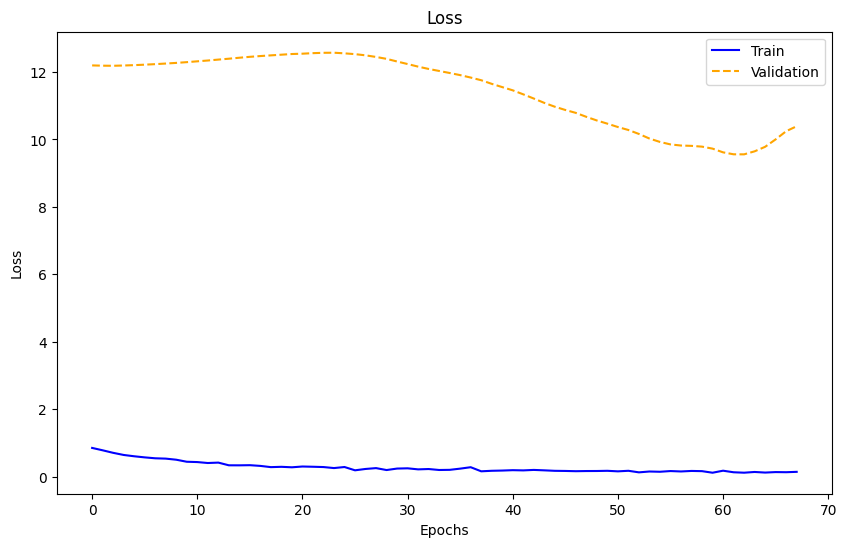

In [680]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train[1:], label='Train', color='blue')
plt.plot(loss_history_val[1:], label='Validation', color='orange', linestyle = '--')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

In [681]:
print(loss_history_train[-100:])

[1.0366357564926147, 0.8495572209358215, 0.7789846658706665, 0.703828752040863, 0.6407930850982666, 0.6016777157783508, 0.5690665245056152, 0.5420194268226624, 0.5322368741035461, 0.49971678853034973, 0.4394451081752777, 0.42993593215942383, 0.40201106667518616, 0.41402769088745117, 0.33404669165611267, 0.333098828792572, 0.33750590682029724, 0.31618183851242065, 0.2796858251094818, 0.28916028141975403, 0.275005966424942, 0.2981582581996918, 0.2910398840904236, 0.2820572555065155, 0.2519580125808716, 0.2832559645175934, 0.18540219962596893, 0.22555196285247803, 0.2507561147212982, 0.1934724897146225, 0.23736101388931274, 0.24471527338027954, 0.21349060535430908, 0.22359208762645721, 0.19504760205745697, 0.19942839443683624, 0.23517325520515442, 0.27741020917892456, 0.15598107874393463, 0.17146576941013336, 0.17823928594589233, 0.18937915563583374, 0.18303389847278595, 0.1970994621515274, 0.18451128900051117, 0.1703951209783554, 0.16648361086845398, 0.15922050178050995, 0.16390460729599

In [682]:
# val_loader, np_val_seq_X, np_val_seq_y = make_data_loader([3])  ##
test_data_x, test_data_y = concatanate_tensors(val_loader, [2])
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)

In [683]:

model.eval()
with torch.no_grad():
    test_data_x = test_data_x.to(device)
    predicted_y_untransformed = model(test_data_x)
    predicted_y_untransformed = predicted_y_untransformed.to("cpu").numpy()
    predicted_y = inverse_scale(scaler_out, predicted_y_untransformed)
    test_data_y = test_data_y.to("cpu").numpy()
    test_data_y = inverse_scale(scaler_out, test_data_y)


In [684]:
x = []
test_data_y = test_data_y.reshape(test_data_y.shape[0])
predicted_y = predicted_y.reshape(predicted_y.shape[0])

print(calculate_NSE(test_data_y, predicted_y))
# predicted_y = predicted_y.reshape(predicted_y.shape[0])

-1.04


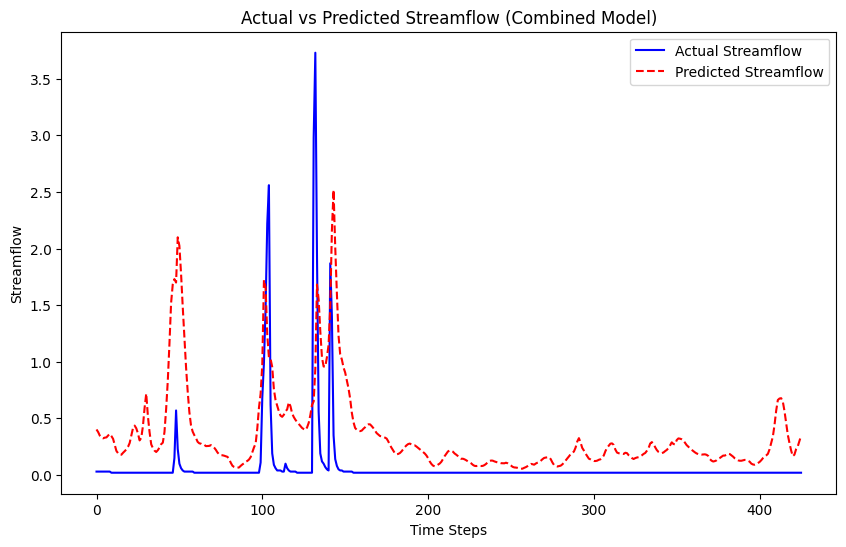

In [685]:
import matplotlib.pyplot as plt

# Plot the actual and predicted streamflow values
plt.figure(figsize=(10, 6))
plt.plot(test_data_y, label='Actual Streamflow', color='blue')
plt.plot(predicted_y, label='Predicted Streamflow', color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Time Steps')
plt.ylabel('Streamflow')
plt.title('Actual vs Predicted Streamflow (Combined Model)')
plt.legend()
